## Part 2: Predict actual power generation by wind plants of SP15 hub on 2024-04-09

I use LSTM model built on PyTorch. The architecture, training and generating prediction can be seen below.
Both DAM and ACTUAL data can be used for generating prediction. I used DAM data up to operating hour 24 4/8/2024 in the training process.

In [41]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [92]:
# Load the provided time series data
file_path = '/Users/lok/5DE/data/DAM.csv'
data = pd.read_csv(file_path)

In [93]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data[['MW']].values)

In [104]:
# Function to create sequences with both actual and predicted data
def create_sequences(input_data, sequence_length):
    xs = []
    ys = []
    for i in range(len(input_data)-sequence_length):
        x = input_data[i:(i+sequence_length), :]
        y = input_data[i+sequence_length, 0]  # We are predicting the next actual value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Creating sequences
sequence_length = 24  # using 24 hours of data to predict the next hour
X, y = create_sequences(normalized_data, sequence_length)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [125]:
class WindGenerationLSTM(nn.Module):
    """
    A PyTorch LSTM model for wind generation forecasting.

    This class implements a neural network with LSTM (Long Short-Term Memory) layers for time series forecasting
    of wind generation data. The network consists of an LSTM layer followed by a linear layer. 

    Attributes:
        hidden_layer_size (int): The size of the hidden layer in the LSTM.
        lstm (nn.LSTM): The LSTM layer of the network.
        linear (nn.Linear): The linear layer of the network.
        hidden_cell (tuple): The hidden and cell states of the LSTM.

    Methods:
        forward(input_seq): Performs the forward pass of the model.
    """

    def __init__(self, input_size=1, hidden_layer_size=5, output_size=1):
        super(WindGenerationLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [116]:
# Instantiating the model
model = WindGenerationLSTM()
loss_function = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) 

# Training the model
epochs = 30

train_losses = []
val_losses = []
# training loop
for epoch in tqdm(range(epochs), desc='Training', unit='epochs'):
    model.train()  # Set the model to training mode
    total_train_loss = 0

    # Training loop
    for seq, labels in zip(X_train_tensor, y_train_tensor):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        labels = labels.unsqueeze(0)

        train_loss = loss_function(y_pred, labels)
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / len(X_train_tensor)
    train_losses.append(avg_train_loss)
    scheduler.step()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0
        for seq, labels in zip(X_val_tensor, y_val_tensor):
            y_pred = model(seq)
            labels = labels.unsqueeze(0)
            val_loss = loss_function(y_pred, labels)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(X_val_tensor)
        val_losses.append(avg_val_loss)


    print(f'Epoch {epoch+1} \t Training Loss: {avg_train_loss:.4f} \t Validation Loss: {avg_val_loss:.4f}')


Training:   0%|          | 0/30 [00:00<?, ?epochs/s]

Epoch 1 	 Training Loss: 0.0376 	 Validation Loss: 0.0991
Epoch 2 	 Training Loss: 0.0246 	 Validation Loss: 0.0599
Epoch 3 	 Training Loss: 0.0156 	 Validation Loss: 0.0353
Epoch 4 	 Training Loss: 0.0110 	 Validation Loss: 0.0243
Epoch 5 	 Training Loss: 0.0086 	 Validation Loss: 0.0187
Epoch 6 	 Training Loss: 0.0071 	 Validation Loss: 0.0151
Epoch 7 	 Training Loss: 0.0060 	 Validation Loss: 0.0125
Epoch 8 	 Training Loss: 0.0051 	 Validation Loss: 0.0106
Epoch 9 	 Training Loss: 0.0044 	 Validation Loss: 0.0090
Epoch 10 	 Training Loss: 0.0039 	 Validation Loss: 0.0077
Epoch 11 	 Training Loss: 0.0034 	 Validation Loss: 0.0067
Epoch 12 	 Training Loss: 0.0030 	 Validation Loss: 0.0059
Epoch 13 	 Training Loss: 0.0026 	 Validation Loss: 0.0051
Epoch 14 	 Training Loss: 0.0023 	 Validation Loss: 0.0045
Epoch 15 	 Training Loss: 0.0021 	 Validation Loss: 0.0040
Epoch 16 	 Training Loss: 0.0018 	 Validation Loss: 0.0036
Epoch 17 	 Training Loss: 0.0016 	 Validation Loss: 0.0032
Epoch 

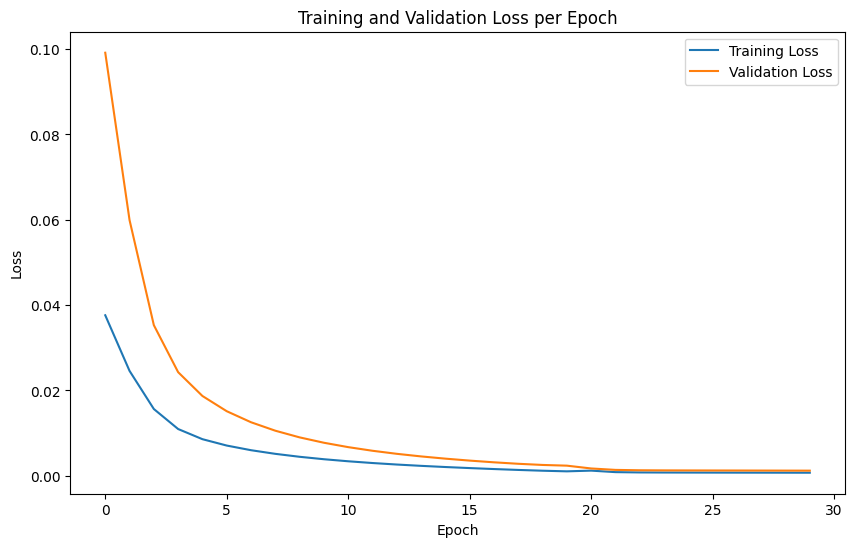

In [121]:
# Plotting the training and validation loss graph
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [122]:
model_save_path = 'models/wind_generation_lstm_model.pt'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

In [118]:
# Assuming 'model' is your trained PyTorch LSTM model
# 'scaler' is your MinMaxScaler instance
# 'data' is your dataset DataFrame with a column 'MW' for wind generation

# Extracting the last 24 hours as the input sequence
last_sequence = data['MW'].values[-24:]

last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))

# Reshape to the format (sequence_length, batch_size, input_size)
input_tensor = torch.tensor(last_sequence_scaled.reshape(24, 1, 1), dtype=torch.float32)

predictions = []

model.eval()  # Set the model to evaluation mode

# Predicting the next 24 hours
for _ in range(24):
    with torch.no_grad():
        pred = model(input_tensor)
        predictions.append(pred.numpy().item())

        # Update the input for the next prediction
        input_tensor = torch.cat((input_tensor[0, 1:, :].unsqueeze(0), torch.tensor([[pred.item()]], dtype=torch.float32).view(1, 1, 1)), 1)

# Inverse transform the predictions if you used scaling
predictions_scaled_back = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [120]:
# Output the same dataframe as requested
date = "2024-04-09"
trading_hub = "SP15"
renewable_type = "Wind"
hours = range(1, 25)  # Hour numbers from 1 to 24

# Create the DataFrame
df = pd.DataFrame({
    "DATE": [date]*24,
    "HE": hours,
    "Trading_Hub": [trading_hub]*24,
    "Renewable_Type": [renewable_type]*24,
    "NW": predictions_scaled_back.flatten()  # Assuming predictions_scaled_back is a 1D array
})

df.to_csv("2024-04-09_Pred_Loc_Tran.csv", index=False)